In [86]:
%pip install opencv-python numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [87]:
import os
import cv2  # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Agar grafik muncul di notebook
%matplotlib inline

print("Library berhasil di-import!")

#end

Library berhasil di-import!


In [88]:
# --- KONFIGURASI ---
DATASET_PATH = "dataset wajah2" # Pastikan path ini benar sesuai folder Anda (Dataset_Wajah atau dataset wajah2)
IMG_SIZE = 160  # Sesuai Janji di Laporan Bab 3.3

def load_dataset(path):
    data = []
    labels = []
    class_names = []
    
    # Cek folder
    if not os.path.exists(path):
        print(f"Error: Folder '{path}' tidak ditemukan!")
        print("Tips: Cek sidebar kiri VS Code, apa nama folder sebenarnya? (Huruf besar/kecil berpengaruh)")
        return np.array(data), np.array(labels), class_names

    print(f"Sedang memeriksa folder: {path} ...")

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        if os.path.isdir(folder_path):
            class_names.append(folder_name)
            label_index = class_names.index(folder_name)
            print(f"--> Memproses kelas: {folder_name}")

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    # 1. Baca Citra
                    img_array = cv2.imread(img_path)
                    if img_array is None: continue 

                    # 2. Grayscaling (Sesuai Laporan)
                    gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                    # 3. Resizing (SUDAH AKTIF KEMBALI - SESUAI LAPORAN)
                    # Kita gunakan IMG_SIZE yang sudah di-set 64 di paling atas
                    resized_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))

                    data.append(resized_img)
                    labels.append(label_index)

                except Exception as e:
                    pass

    data = np.array(data)
    labels = np.array(labels)
    
    print(f"\nSelesai! Total Data: {len(data)} citra.")
    
    # Validasi output untuk memastikan resize berhasil
    if len(data) > 0:
        print(f"Dimensi Citra: {data.shape[1]}x{data.shape[2]} (Sesuai Laporan)")
    
    return data, labels, class_names

# --- EKSEKUSI ---
data, labels, class_names = load_dataset(DATASET_PATH)

if len(data) > 0:
    print("Dataset siap digunakan untuk Training!")

Sedang memeriksa folder: dataset wajah2 ...
--> Memproses kelas: Brad Pitt
--> Memproses kelas: Camila Cabello
--> Memproses kelas: Claire Holt
--> Memproses kelas: Courtney Cox
--> Memproses kelas: Dwayne Johnson
--> Memproses kelas: Ellen Degeneres
--> Memproses kelas: Jessica Alba
--> Memproses kelas: Lisa Kudrow

Selesai! Total Data: 400 citra.
Dimensi Citra: 160x160 (Sesuai Laporan)
Dataset siap digunakan untuk Training!


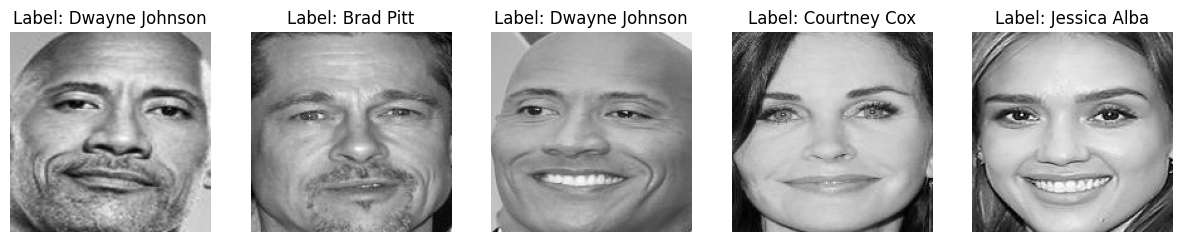

In [89]:
# Menampilkan 5 sampel acak
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(data))
    plt.subplot(1, 5, i+1)
    plt.imshow(data[idx], cmap='gray')
    plt.title(f"Label: {class_names[labels[idx]]}")
    plt.axis('off')
plt.show()

#end

In [90]:
# 1. Flattening: Mengubah (N, 64, 64) menjadi (N, 4096)
X = data.reshape(len(data), -1) # -1 otomatis menghitung 64*64
y = labels

print(f"Dimensi Data Sebelum Flatten: {data.shape}")
print(f"Dimensi Data Setelah Flatten: {X.shape} (Siap untuk KNN)")

# 2. Split Data (80% Latih, 20% Uji) - Skenario 2 Bab 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah Data Latih: {len(X_train)}")
print(f"Jumlah Data Uji: {len(X_test)}")

#end

Dimensi Data Sebelum Flatten: (400, 160, 160)
Dimensi Data Setelah Flatten: (400, 25600) (Siap untuk KNN)
Jumlah Data Latih: 320
Jumlah Data Uji: 80


Mulai Pengujian Nilai K...
------------------------------
|  Nilai K  |  Akurasi (80:20)  |
------------------------------
|    K=1    |     67.50%     |
|    K=3    |     61.25%     |
|    K=5    |     68.75%     |
|    K=7    |     65.00%     |
|    K=9    |     70.00%     |
------------------------------


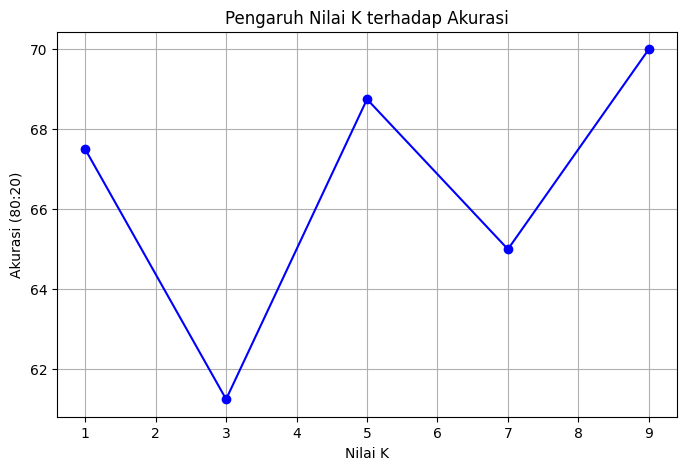

In [97]:
k_values = [1, 3, 5, 7, 9]
accuracies = []

print("Mulai Pengujian Nilai K...")
print("-" * 30)
print("|  Nilai K  |  Akurasi (80:20)  |")
print("-" * 30)

for k in k_values:
    # Membuat model KNN
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies.append(acc)

    print(f"|    K={k}    |     {acc:.2f}%     |")

print("-" * 30)

# Visualisasi Grafik (Elbow Method sederhana)
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Pengaruh Nilai K terhadap Akurasi')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (80:20)')
plt.grid(True)
plt.show()


#end


--- Laporan Klasifikasi (K=9) ---
                 precision    recall  f1-score   support

      Brad Pitt       0.50      0.80      0.62        10
 Camila Cabello       1.00      0.80      0.89        10
    Claire Holt       0.73      0.80      0.76        10
   Courtney Cox       0.86      0.60      0.71        10
 Dwayne Johnson       0.88      0.70      0.78        10
Ellen Degeneres       0.62      0.50      0.56        10
   Jessica Alba       0.67      0.80      0.73        10
    Lisa Kudrow       0.60      0.60      0.60        10

       accuracy                           0.70        80
      macro avg       0.73      0.70      0.70        80
   weighted avg       0.73      0.70      0.70        80



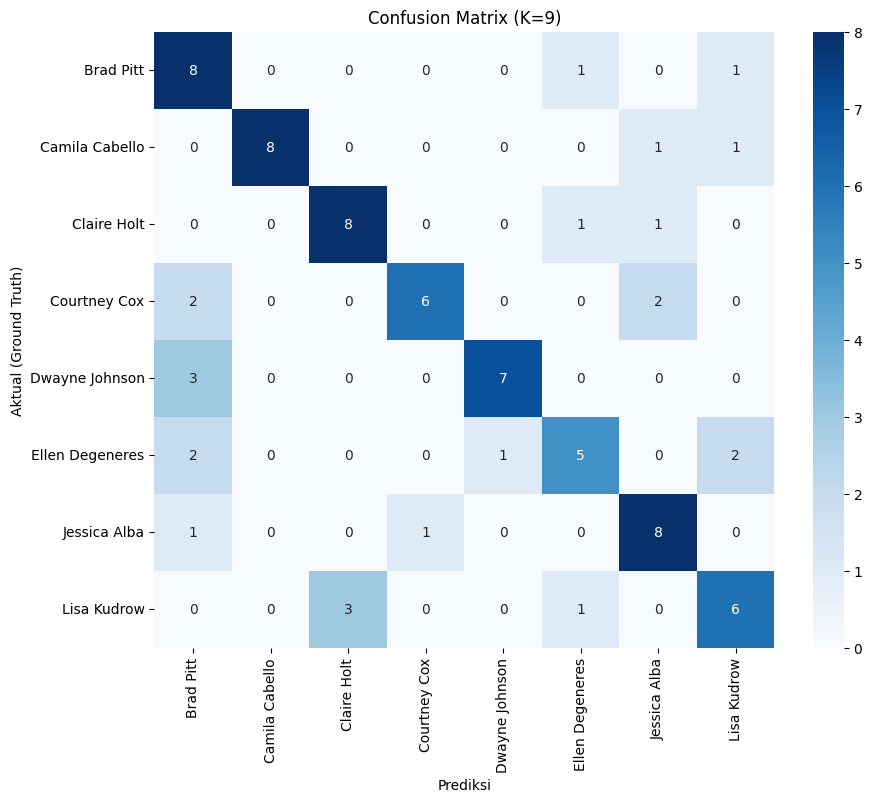

In [92]:
# Ambil K terbaik (misal K=3 berdasarkan grafik di atas)
BEST_K = 9
final_model = KNeighborsClassifier(n_neighbors=BEST_K, metric='euclidean')
final_model.fit(X_train, y_train)

# Prediksi Akhir
y_pred_final = final_model.predict(X_test)

# --- 1. CLASSIFICATION REPORT (Presisi, Recall, F1) ---
print(f"\n--- Laporan Klasifikasi (K={BEST_K}) ---")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# --- 2. CONFUSION MATRIX (Gambar 4.1 di Laporan) ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (Ground Truth)')
plt.title(f'Confusion Matrix (K={BEST_K})')
plt.show()

#end

Jarak terdekat: 6193.54
Sistem: Wajah Dikenali sebagai Courtney Cox


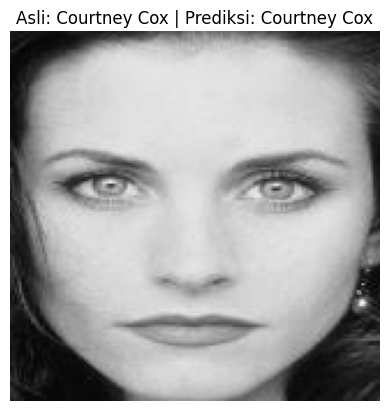

In [93]:
def simulasi_absensi(index_test):
    # Ambil satu gambar dari data uji
    img_test = X_test[index_test].reshape(1, -1) # Flatten ulang
    actual_label = class_names[y_test[index_test]]

    # Cari jarak ke tetangga terdekat (Logika Threshold di Flowchart)
    distances, indices = final_model.kneighbors(img_test)
    min_distance = distances[0][0] # Jarak terdekat

    # Tentukan Threshold (Misal 2000, sesuaikan dengan percobaan)
    THRESHOLD = 10000 # Angka ini harus disesuaikan saat run program
    
    print(f"Jarak terdekat: {min_distance:.2f}")

    if min_distance > THRESHOLD:
        print("Sistem: Wajah TIDAK Dikenali (Jarak terlalu jauh)")
        pred_label = "Unknown"
    else:
        pred_index = final_model.predict(img_test)[0]
        pred_label = class_names[pred_index]
        print(f"Sistem: Wajah Dikenali sebagai {pred_label}")

    # Tampilkan Gambar
    plt.imshow(X_test[index_test].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Asli: {actual_label} | Prediksi: {pred_label}")
    plt.axis('off')
    plt.show()

# Coba simulasi pada data ke-10 di set pengujian
simulasi_absensi(3)

#end

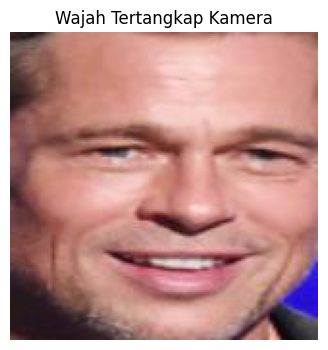


--- HASIL ANALISIS SISTEM ---
Jarak Kemiripan: 6041.10
🟢 Status: ABSEN BERHASIL!
👤 Identitas: Brad Pitt


In [94]:
# --- SIMULASI ABSENSI DENGAN FOTO EKSTERNAL (REAL-WORLD TEST) ---

def tes_foto_baru(path_file_gambar):
    """
    Fungsi ini mensimulasikan kamera menangkap wajah seseorang.
    Kita ambil file gambar dari luar dataset, lalu suruh AI menebak.
    """
    
    # 1. Cek apakah file ada
    if not os.path.exists(path_file_gambar):
        print(f"Error: File '{path_file_gambar}' tidak ditemukan!")
        return

    # 2. Baca Gambar
    img_real = cv2.imread(path_file_gambar)
    if img_real is None:
        print("Error: Gambar tidak bisa dibaca.")
        return
    
    # Tampilkan Gambar Asli
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    plt.title("Wajah Tertangkap Kamera")
    plt.axis('off')
    plt.show()

    try:
        # 3. Pra-pemrosesan (Harus SAMA PERSIS dengan Training)
        # a. Grayscale
        gray_new = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)
        
        # b. Resize (WAJIB 160x160 sesuai model Anda)
        resized_new = cv2.resize(gray_new, (IMG_SIZE, IMG_SIZE))
        
        # c. Flatten (Jadi 1 baris)
        flat_new = resized_new.reshape(1, -1)

        # 4. Prediksi (KNN Magic)
        distances, indices = final_model.kneighbors(flat_new)
        min_dist = distances[0][0]
        
        # 5. Logika Absensi (Threshold)
        # Ingat: Karena size 160x160, jaraknya bakal besar (ribuan/puluhan ribu)
        # Sesuaikan THRESHOLD ini saat demo sampai pas.
        THRESHOLD_DEMO = 25000 
        
        print(f"\n--- HASIL ANALISIS SISTEM ---")
        print(f"Jarak Kemiripan: {min_dist:.2f}")
        
        if min_dist > THRESHOLD_DEMO:
            print("🔴 Status: WAJAH TIDAK DIKENALI (Orang Asing / Bukan Mahasiswa)")
        else:
            pred_index = final_model.predict(flat_new)[0]
            nama_prediksi = class_names[pred_index]
            print(f"🟢 Status: ABSEN BERHASIL!")
            print(f"👤 Identitas: {nama_prediksi}")
            
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# --- CARA PAKAI SAAT DEMO ---
# 1. Siapkan 1 foto wajah teman (misal 'tes_wajah.jpg') di folder yang sama dengan kode ini.
# 2. Panggil fungsinya:
tes_foto_baru("Brad Pitt_118.jpg")


=== PENGUJIAN RASIO 70:30 ===
Data Latih: 280 citra
Data Uji  : 120 citra
----------------------------------------
|  Nilai K  |  Akurasi (70:30)  |
----------------------------------------
|    K=1    |     61.67%      |
|    K=3    |     60.83%      |
|    K=5    |     64.17%      |
|    K=7    |     65.83%      |
|    K=9    |     65.83%      |
----------------------------------------


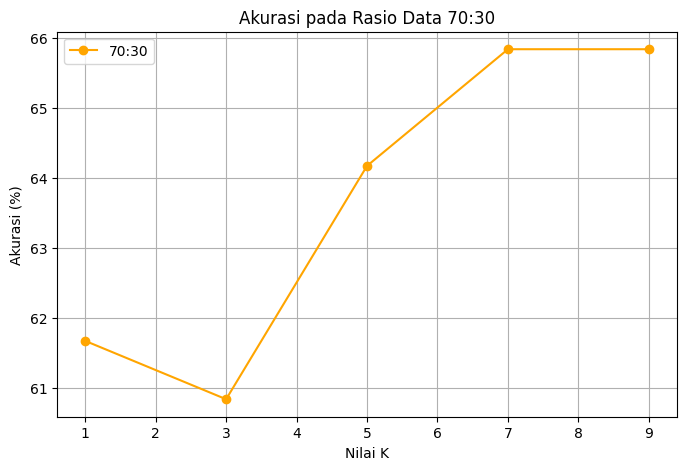

In [100]:
# --- SKENARIO 2.A: PENGUJIAN RASIO 70:30 ---
print("\n=== PENGUJIAN RASIO 70:30 ===")

# 1. Split Data (70% Latih, 30% Uji)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_70)} citra")
print(f"Data Uji  : {len(X_test_30)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_70 = [] # List untuk menyimpan nilai akurasi agar bisa di-plot

print("-" * 40)
print("|  Nilai K  |  Akurasi (70:30)  |")
print("-" * 40)

for k in k_values:
    model_70 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_70.fit(X_train_70, y_train_70)
    y_pred_70 = model_70.predict(X_test_30)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_30, y_pred_70) * 100
    accuracies_70.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 70:30 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_70, marker='o', linestyle='-', color='orange', label='70:30')
plt.title('Akurasi pada Rasio Data 70:30')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()


=== PENGUJIAN RASIO 90:10 ===
Data Latih: 360 citra
Data Uji  : 40 citra
----------------------------------------
|  Nilai K  |  Akurasi (90:10)  |
----------------------------------------
|    K=1    |     67.50%      |
|    K=3    |     65.00%      |
|    K=5    |     65.00%      |
|    K=7    |     67.50%      |
|    K=9    |     75.00%      |
----------------------------------------


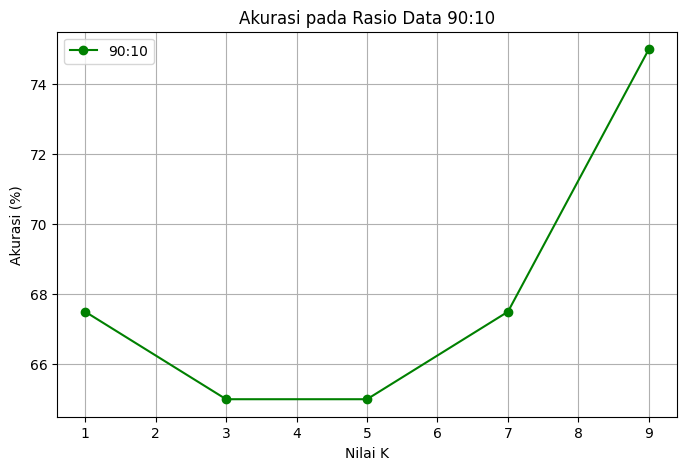

In [101]:
# --- SKENARIO 2.B: PENGUJIAN RASIO 90:10 ---
print("\n=== PENGUJIAN RASIO 90:10 ===")

# 1. Split Data (90% Latih, 10% Uji)
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_90)} citra")
print(f"Data Uji  : {len(X_test_10)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_90 = [] # List wajib ada untuk grafik

print("-" * 40)
print("|  Nilai K  |  Akurasi (90:10)  |")
print("-" * 40)

for k in k_values:
    model_90 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_90.fit(X_train_90, y_train_90)
    y_pred_90 = model_90.predict(X_test_10)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_10, y_pred_90) * 100
    accuracies_90.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 90:10 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_90, marker='o', linestyle='-', color='green', label='90:10')
plt.title('Akurasi pada Rasio Data 90:10')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

Grafik berhasil disimpan sebagai 'Grafik_Linearitas_OpenLoop.png'


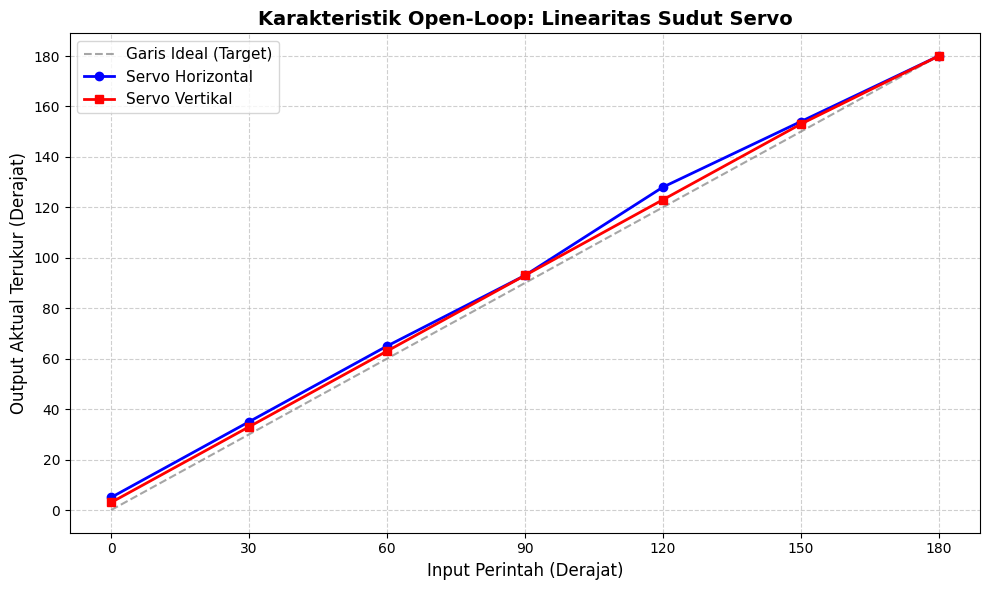

In [8]:
import matplotlib.pyplot as plt

# --- DATA PENGUKURAN (Dari eksperimen manual kamu) ---
input_command = [0, 30, 60, 90, 120, 150, 180]       # Sumbu X (Perintah)
output_hori   = [5, 35, 65, 93, 128, 154, 180]       # Sumbu Y (Horizontal)
output_vert   = [3, 33, 63, 93, 123, 153, 180]       # Sumbu Y (Vertikal)

# Membuat Plot
plt.figure(figsize=(10, 6)) # Ukuran gambar (10x6 inch)

# 1. Garis Referensi Ideal (Garis Putus-putus)
# Ini menunjukkan kalau alat sempurna (0=0, 180=180)
plt.plot(input_command, input_command, linestyle='--', color='gray', label='Garis Ideal (Target)', alpha=0.7)

# 2. Plot Data Horizontal (Garis Biru dengan titik Bulat)
plt.plot(input_command, output_hori, marker='o', linestyle='-', color='blue', label='Servo Horizontal', linewidth=2)

# 3. Plot Data Vertikal (Garis Merah dengan titik Kotak)
plt.plot(input_command, output_vert, marker='s', linestyle='-', color='red', label='Servo Vertikal', linewidth=2)

# --- MEMPERCANTIK GRAFIK (Sesuai Standar Laporan) ---
plt.title('Karakteristik Open-Loop: Linearitas Sudut Servo', fontsize=14, fontweight='bold')
plt.xlabel('Input Perintah (Derajat)', fontsize=12)
plt.ylabel('Output Aktual Terukur (Derajat)', fontsize=12)

# Mengatur skala sumbu agar pas
plt.xticks(range(0, 190, 30)) # Kelipatan 30 di sumbu X
plt.yticks(range(0, 200, 20)) # Kelipatan 20 di sumbu Y

plt.grid(True, linestyle='--', alpha=0.6) # Grid kotak-kotak tipis
plt.legend(fontsize=11) # Menampilkan keterangan warna

# --- SIMPAN GAMBAR OTOMATIS ---
plt.tight_layout()
plt.savefig('Grafik_Linearitas_OpenLoop.png', dpi=300) # Simpan resolusi tinggi (300 DPI)
print("Grafik berhasil disimpan sebagai 'Grafik_Linearitas_OpenLoop.png'")

# Tampilkan grafik di layar
plt.show()